# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\aliap\Cornell\BEE 4750\hw2-trent-ali-FINAL`


In [3]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

The maximum concentration of CRUD in the river, 2.007522578289671 kg/1000 m³, falls below the regulatory limit of 2.5 kg/1000 m³


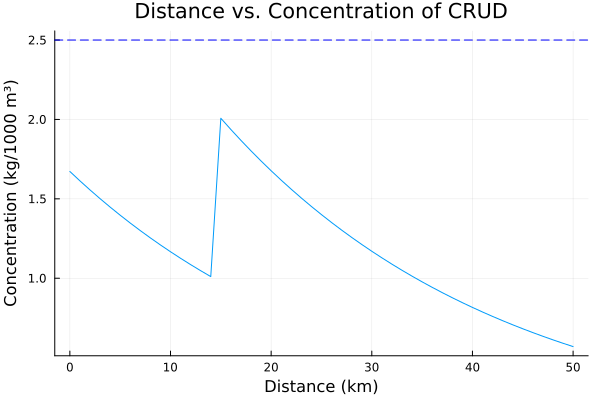

In [18]:
using Plots


function conc_CRUD(d)
    v = 10  # velocity km/day
    k = 0.36  # decay constant d^(-1)
   
    # River + first discharge 
    Q_river = 250000  # river flow rate ( m³/day)
    C_river = 0.5  # conc of river inflow (kg/1000m³) 
   
    Q1 = 40000  # first input rate (m³/day)
    C1 = 9  # conc of first discharge (kg/1000m³)
   
    # Second discharge 
    Q2 = 60_000  # second discharge rate in m³/day
    C2 = 7  # conc of second discharge in kg/1000m³ 
    if d < 15
        # Conc for distances before the second discharge
        c = ((Q_river * C_river) + (Q1 * C1)) / (Q_river + Q1) * exp(-k * (d / v))
    else
        # Conc at 15 km (right before second discharge)
        c15 = ((Q_river * C_river) + (Q1 * C1)) / (Q_river + Q1) * exp(-k * (15 / v))
        # Conc for distances after second discharge
        c = ((((Q_river + Q1) * c15) + (Q2 * C2)) / (Q_river + Q1 + Q2)) * exp(-k * ((d - 15) / v))
    end


    return c
end


# Define distances and calculate concentrations
distances = 0:1:50
concentrations = [conc_CRUD(d) for d in distances]


# Check if the maximum concentration falls below the regulatory limit
reg_limit = 2.5  # kg/1000 m³
max_c=maximum(concentrations)
if max_c < reg_limit
    println("The maximum concentration of CRUD in the river, $max_c kg/1000 m³, falls below the regulatory limit of $reg_limit kg/1000 m³")
else
    println("The maximum concentration of CRUD in the river, $max_c kg/1000 m³,  is above the regulatory limit of $reg_limit kg/1000 m³, see graph for more details")
end


# Plot the concentration along the river with the regulatory limit
plot(distances, concentrations, xlabel="Distance (km)", ylabel="Concentration (kg/1000 m³)", title="Distance vs. Concentration of CRUD", legend=false)
hline!([reg_limit], linestyle=:dash, color=:blue, label="Regulatory Limit ($reg_limit kg/1000 m³)")





____________________explanation____________________________


For this question I seperated the situations into before and after input 2. If the distance was before input 2, the concentration was a simple mole balance to find Co: c = ((Q_river * C_river) + (Q1 * C1)) / (Q_river + Q1) 
, then multiplying an exponential decay term: * exp(-k * (d / v)). 


If the distance was after 15km, then I had to do a mole balance of whatever the flow was into d=15 (c15):c15 = ((Q_river * C_river) + (Q1 * C1)) / (Q_river + Q1) * exp(-k * (15 / v))


with the input 2, then apply the decay term:   c = ((((Q_river + Q1) * c15) + (Q2 * C2)) / (Q_river + Q1 + Q)) * exp(-k * ((d - 15) / v))




____________________explanation____________________________

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

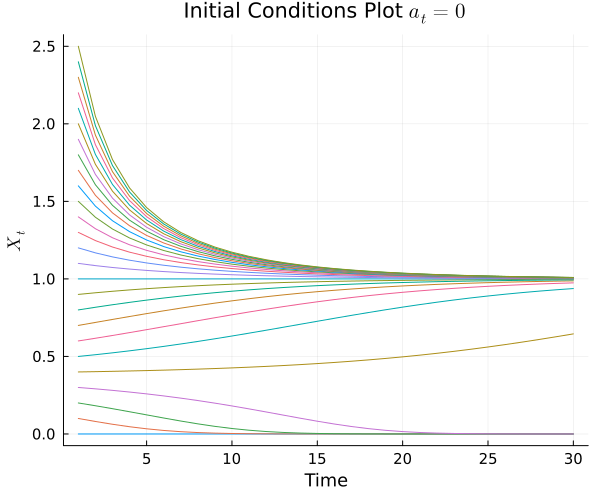

In [8]:
# Define functions for lake recycling and outflows (Class Slides)
lake_cycling(x, q) = x.^q ./ (1 .+ x.^q);
lake_outflow(x, b) = b .* x;

T = 30
X_vals = collect(0.0:0.1:2.5)
function simulate_lake(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t].+ lake_cycling(X[t-1], q) .- lake_outflow(X[t-1], b)
    end
    return X
end

lake_delta(x, b, q, a) = a + lake_cycling(x,q) - lake_outflow(x,b)

# Make an initial conditions plot for the model dynamics for b=0.5, q=1.5, y_t=0, and a_t=0 for t: 0-30.
X = map(x -> simulate_lake(x, T, 0.5, 1.5, zeros(T), zeros(T)), X_vals)
p_noinflow = plot(X, label=false, ylabel=L"X_t", xlabel="Time", guidefontsize=12, tickfontsize=10, size=(600, 500), title = L"Initial Conditions Plot $a_t=0$")

I defined lake cycling and outflow parameters according to the provided formula. In a master formula incorporating the first two, I iteratively marched through the numerical model for $T = 2-30$, generating a curve for a given $X$ value intial condition (at $T=1$). This master function, simulate_lake, was mapped to initial condition values from 0-2.5 with 0.1 precision. Below, roots (equilibria) are found for the $X_i = X_{i+1}$ case, as instructed.

In [12]:
# Find equilibria for the model dynamics for b=0.5, q=1.5, y_t=0, and a_t=0 for t: 0-30.
    a = Roots.find_zero(x -> lake_delta(x,0.5,1.5,0), 1)
    b = Roots.find_zero(x -> lake_delta(x,0.5,1.5,0), 0.5)
    c =Roots.find_zero(x -> lake_delta(x,0.5,1.5,0), 0)
    @show (a,b,c)

(1.0, 0.3819660112501051, 0.0)

(a, b, c) = (1.0, 0.3819660112501051, 0.0)


The equilibria for the given conditions (a = 0) are located at 1 and 0 (stable) and 0.382 (unstable).
The system is especially resillient above 1.0 and a little below it. Towards around 0.5 stability decreases until an unstable equilibrium is reached. The subsequent stable equilibrium at 0.0 is less resilient than the one at 1.0.

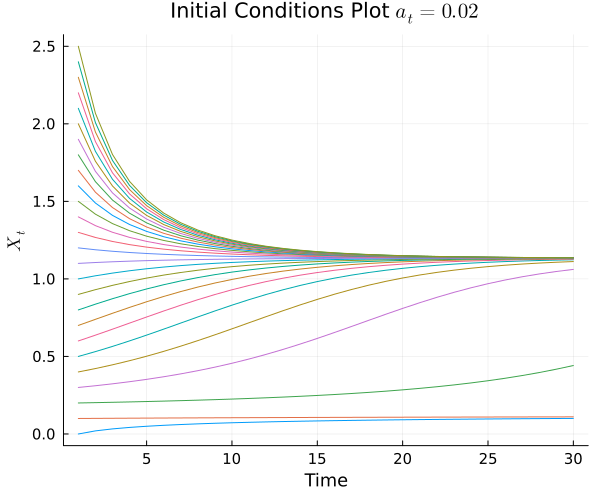

In [9]:
# Make an initial conditions plot for the model dynamics for b=0.5, q=1.5, y_t=0, and a_t=0.02 for t: 0-30.
X = map(x -> simulate_lake(x, T, 0.5, 1.5, 0.02*ones(T), zeros(T)), X_vals)
p_noinflow = plot(X, label=false, ylabel=L"X_t", xlabel="Time", guidefontsize=12, tickfontsize=10, size=(600, 500), title = L"Initial Conditions Plot $a_t=0.02$")

In [10]:

# Find equilibria for the model dynamics for b=0.5, q=1.5, y_t=0, and a_t=0.02 for t: 0-30.
a = Roots.find_zero(x -> lake_delta(x,0.5,1.5,0.02), 1)
b =Roots.find_zero(x -> lake_delta(x,0.5,1.5,0.02), 0.5)
c =Roots.find_zero(x -> lake_delta(x,0.5,1.5,0.02), 0)
@show (a,b,c)

(1.1341008852434813, 0.15442860418310417, 0.1162444196607475)

(a, b, c) = (1.1341008852434813, 0.15442860418310417, 0.1162444196607475)


The equilibria for the given conditions (a = 0.02) are located at 1.134 and 0.116 (stable) and 0.154 (unstable).
The stable equilibrium points increased in magnitude and the unstable one decreased. The system is just as resilient above 1.134 as the previous iteration. Due to the lowering of the unstable equilibrium, this system is arguably more resilient below 1.134 than the a=0 case was below 1.0 (i.e., lines converge to the equilibrium for lower X values). Nevertheless, the second stable equilibrium is ostensibly less resilient.

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.